# Univariate CC for Small Shifts

## Exercise 1
The data stored in `ESE09_ex1.csv` represent the mean values of a quantity measured in samples of size $ n = 5 $ taken from a population with $ \sigma = 1 $. 
1. Design a CUSUM chart (with parameters $ h = 4 $ and $ k = 0.5 $) and an EWMA (with param. $ \lambda = 0.2 $) and discuss the results (neglect possible non-random patterns).
2. Re-design the CUSUM and EWMA charts (with the same parameters used before) assuming that the mean value of the process under in-control condition is known and is equal to $\mu = 10.75$. Discuss the results. 

In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import qda

# Import the dataset
data = pd.read_csv('ESE09_ex1.csv')

# Inspect the dataset
data.head()

,EXE4
0,10.45
1,10.55
2,10.37
3,10.64
4,10.95


Visualize the data.

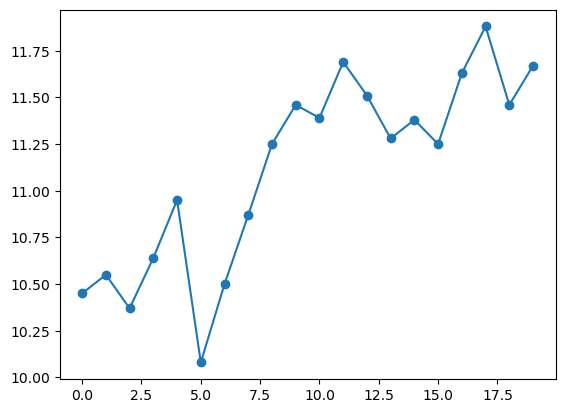

In [2]:
# plot the data
plt.plot(data,'o-')
plt.show()

What happens if we design a CC for the mean (I)? 

We can compute:
$$ \sigma_{\bar{x}} = \frac{\sigma}{\sqrt{n}} = \frac{1}{\sqrt{5}} = 0.4472 $$
$$ \mu_0 = \bar{\bar{x}} = 11.113 $$
Then, we can compute the control limits for the I chart. 

In [3]:
n = 5
sigma = 1
sigma_xbar = sigma/np.sqrt(n)
xbarbar = data['EXE4'].mean()

# make a copy of the data
df = data.copy()
# change the name of the column time to I
df.rename(columns={'EXE4':'I'}, inplace=True)

# Create columns for the upper and lower control limits
df['I_UCL'] = xbarbar + 3*sigma_xbar
df['I_CL'] = xbarbar
df['I_LCL'] = xbarbar - 3*sigma_xbar

# Print the first 5 rows of the new dataframe
df.head()

,I,I_UCL,I_CL,I_LCL
0,10.45,12.454641,11.113,9.771359
1,10.55,12.454641,11.113,9.771359
2,10.37,12.454641,11.113,9.771359
3,10.64,12.454641,11.113,9.771359
4,10.95,12.454641,11.113,9.771359


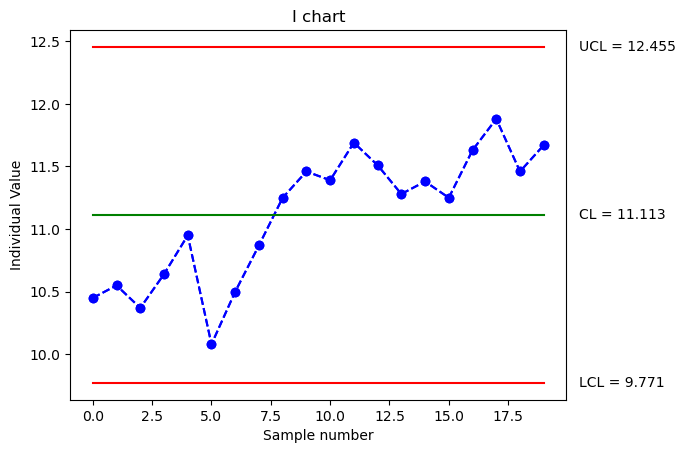

In [4]:
# Plot the I chart
plt.title('I chart')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I_UCL'], color='r')
plt.plot(df['I_CL'], color='g')
plt.plot(df['I_LCL'], color='r')
plt.ylabel('Individual Value')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(df)+.5, df['I_UCL'].iloc[0], 'UCL = {:.3f}'.format(df['I_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['I_CL'].iloc[0], 'CL = {:.3f}'.format(df['I_CL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['I_LCL'].iloc[0], 'LCL = {:.3f}'.format(df['I_LCL'].iloc[0]), verticalalignment='center')
plt.show()

We may detect an OOC using run rules. 

### Point 1
Design a CUSUM chart (with parameters $ h = 4 $ and $ k = 0.5 $) and an EWMA (with param. $ \lambda = 0.2 $) and discuss the results (neglect possible non-random patterns).

Design the CUSUM control chart. Remember:
- $ C_i^+ = \max(0, \bar{x}_i - (\mu_0 + K) + C_{i-1}^+) $
- $ C_i^- = \max(0, (\mu_0 - K) - \bar{x}_i + C_{i-1}^-) $
- $ H = h \cdot \sigma_{\bar{x}} = 4 \cdot 0.4472 = 1.7889 $
- $ K = k \cdot \sigma_{\bar{x}} = 0.5 \cdot 0.4472 = 0.2236 $

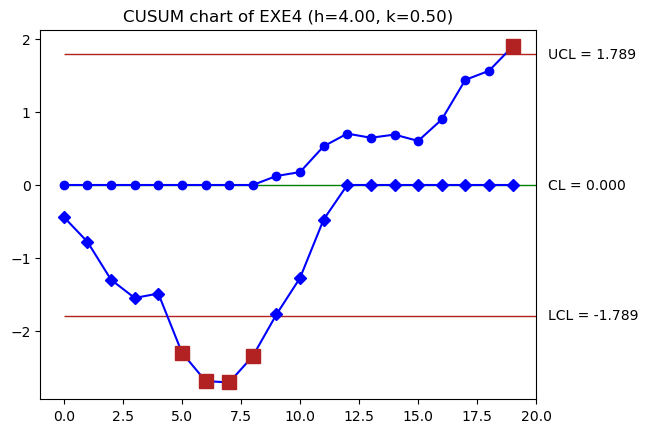

In [5]:
col_name = 'EXE4'

h = 4
k = 0.5

H = h*sigma_xbar
K = k*sigma_xbar

df_CUSUM = data.copy()
df_CUSUM['Ci+'] = 0.0
df_CUSUM['Ci-'] = 0.0
for i in range(len(df_CUSUM)):
    if i == 0:
        df_CUSUM.loc[i, 'Ci+'] = max(0, df_CUSUM.loc[i, col_name] - (xbarbar + K))
        df_CUSUM.loc[i, 'Ci-'] = max(0, (xbarbar - K) - df_CUSUM.loc[i, col_name])
    else:
        df_CUSUM.loc[i, 'Ci+'] = max(0, df_CUSUM.loc[i, col_name] - (xbarbar + K) + df_CUSUM.loc[i-1, 'Ci+'])
        df_CUSUM.loc[i, 'Ci-'] = max(0, (xbarbar - K) - df_CUSUM.loc[i, col_name] + df_CUSUM.loc[i-1, 'Ci-'])

df_CUSUM['Ci+_TEST1'] = np.where((df_CUSUM['Ci+'] > H) | (df_CUSUM['Ci+'] < -H), df_CUSUM['Ci+'], np.nan)
df_CUSUM['Ci-_TEST1'] = np.where((df_CUSUM['Ci-'] > H) | (df_CUSUM['Ci-'] < -H), df_CUSUM['Ci-'], np.nan)

# Plot the control limits
plt.hlines(H, 0, len(df_CUSUM), color='firebrick', linewidth=1)
plt.hlines(0, 0, len(df_CUSUM), color='g', linewidth=1)
plt.hlines(-H, 0, len(df_CUSUM), color='firebrick', linewidth=1)
# Plot the chart
plt.title('CUSUM chart of %s (h=%.2f, k=%.2f)' % (col_name, h, k))
plt.plot(df_CUSUM['Ci+'], color='b', linestyle='-', marker='o')
plt.plot(-df_CUSUM['Ci-'], color='b', linestyle='-', marker='D')
# add the values of the control limits on the right side of the plot
plt.text(len(df_CUSUM)+.5, H, 'UCL = {:.3f}'.format(H), verticalalignment='center')
plt.text(len(df_CUSUM)+.5, 0, 'CL = {:.3f}'.format(0), verticalalignment='center')
plt.text(len(df_CUSUM)+.5, -H, 'LCL = {:.3f}'.format(-H), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(df_CUSUM['Ci+_TEST1'], linestyle='none', marker='s', color='firebrick', markersize=10)
plt.plot(-df_CUSUM['Ci-_TEST1'], linestyle='none', marker='s', color='firebrick', markersize=10)
plt.xlim(-1, len(df_CUSUM))
plt.show()

Design the EWMA control chart. Remember:
- $ z_0 = \bar{\bar{x}} = 11.113 $
- $ z_i = \lambda \cdot \bar{x}_i + (1 - \lambda) \cdot z_{i-1} $
- $ a_t = \frac{\lambda}{2-\lambda} \cdot [1 - (1 - \lambda)^{2t}] $

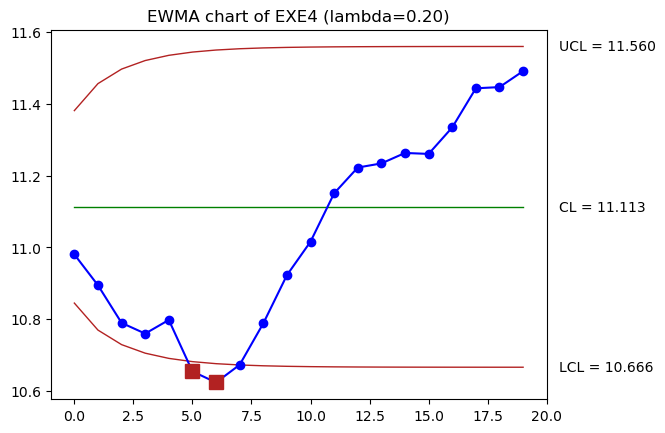

In [6]:
lambda_ = 0.2

df_EWMA = data.copy()
df_EWMA['a_t'] = lambda_/(2-lambda_) * (1 - (1-lambda_)**(2*np.arange(1, len(df_EWMA)+1)))
for i in range(len(df_EWMA)):
    if i == 0:
        df_EWMA.loc[i, 'z'] = lambda_*df_EWMA.loc[i, col_name] + (1-lambda_)*xbarbar
    else:
        df_EWMA.loc[i, 'z'] = lambda_*df_EWMA.loc[i, col_name] + (1-lambda_)*df_EWMA.loc[i-1, 'z']
df_EWMA['UCL'] = xbarbar + 3*sigma_xbar*np.sqrt(df_EWMA['a_t'])
df_EWMA['CL'] = xbarbar
df_EWMA['LCL'] = xbarbar - 3*sigma_xbar*np.sqrt(df_EWMA['a_t'])

df_EWMA['z_TEST1'] = np.where((df_EWMA['z'] > df_EWMA['UCL']) | (df_EWMA['z'] < df_EWMA['LCL']), df_EWMA['z'], np.nan)

# Plot the control limits
plt.plot(df_EWMA['UCL'], color='firebrick', linewidth=1)
plt.plot(df_EWMA['CL'], color='g', linewidth=1)
plt.plot(df_EWMA['LCL'], color='firebrick', linewidth=1)
# Plot the chart
plt.title('EWMA chart of %s (lambda=%.2f)' % (col_name, lambda_))
plt.plot(df_EWMA['z'], color='b', linestyle='-', marker='o')
# add the values of the control limits on the right side of the plot
plt.text(len(df_EWMA)+.5, df_EWMA['UCL'].iloc[-1], 'UCL = {:.3f}'.format(df_EWMA['UCL'].iloc[-1]), verticalalignment='center')
plt.text(len(df_EWMA)+.5, df_EWMA['CL'].iloc[-1], 'CL = {:.3f}'.format(df_EWMA['CL'].iloc[-1]), verticalalignment='center')
plt.text(len(df_EWMA)+.5, df_EWMA['LCL'].iloc[-1], 'LCL = {:.3f}'.format(df_EWMA['LCL'].iloc[-1]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(df_EWMA['z_TEST1'], linestyle='none', marker='s', color='firebrick', markersize=10)
plt.xlim(-1, len(df_EWMA))
plt.show()

### Point 2
Re-design the CUSUM and EWMA charts (with the same parameters used before) assuming that the mean value of the process under in-control condition is known and is equal to $\mu = 10.75$. Discuss the results. 

What if we assume a different mean? Use $\mu = 10.75$ and $\sigma = 1$.

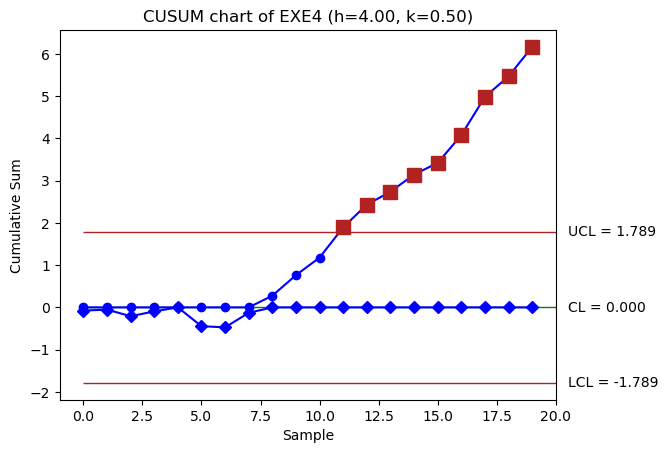

In [7]:
df_CUSUM = qda.ControlCharts.CUSUM(data, 'EXE4', params=(h,k), mean = 10.75, sigma_xbar = sigma_xbar)

In this case, we can signal an alarm starting from obs. 13. 

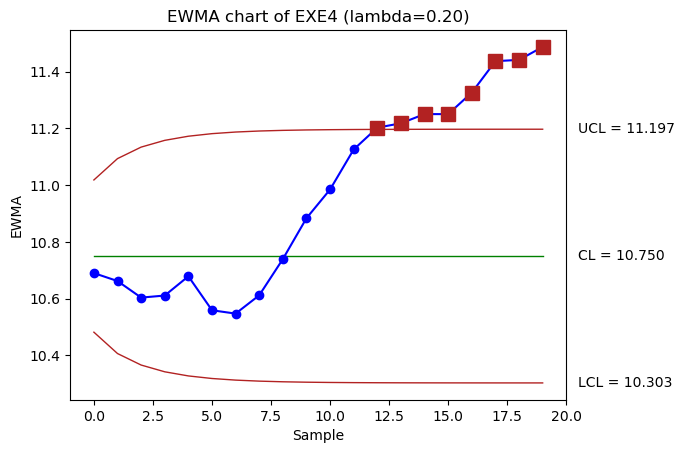

In [8]:
df_EWMA = qda.ControlCharts.EWMA(data, 'EXE4', lambda_, 10.75, sigma_xbar)